In [1]:
--------------------------------------------------------------------------------
-- Loading dataset to ram and sorting triplets
--------------------------------------------------------------------------------
-- Alfredo Canziani, Apr 15
--------------------------------------------------------------------------------

require 'image'
require 'sys'
require 'xlua'

torch.setdefaulttensortype('torch.FloatTensor')

local dataset = {}
local imageSide = 224


-- Loading the dataset to RAM --------------------------------------------------
if paths.filep('dataset.t7') then
   io.write('Loading whole data set. Please wait...'); io.flush()
   dataset = torch.load('dataset.t7')
   print(' Done.')
else
   -- This script uses pubfig83.v1.tgz from http://vision.seas.harvard.edu/pubfig83/
   -- split in train and test folders
   -- each containing identities folders with images inside.
   -- Format:
   -- datasetRoot/{train,test}/<celebrityName>
   local datasetPaths = {}
   datasetPaths.base = 'pubfig83'

   for _, t in ipairs {'train', 'test'} do
      print('Building ' .. t .. 'ing data set')

      datasetPaths[t] = datasetPaths.base .. '/' .. t .. '/'
      local identities = sys.ls(datasetPaths[t]):split('\n')
        print(identities)
      local dataSize = tonumber(sys.execute('find ' .. datasetPaths[t] .. ' -iname "*.jpg"| wc -l'))
        print(dataSize)
      dataset[t] = {
         data = torch.Tensor(dataSize, 3, imageSide, imageSide),
         label = torch.Tensor(dataSize),
         index = torch.Tensor(#identities, 2),
      }

        
      local count = 0
      for id, idName in ipairs(identities) do
         dataset[t].index[id][1] = count + 1
         for _, img in ipairs(sys.ls(datasetPaths[t] .. idName):split('\n')) do
            count = count + 1
            xlua.progress(count, dataSize)
            -- print(count, paths.concat(datasetPaths[t], idName, img))
            local original = image.load(paths.concat(datasetPaths[t], idName, img))
            local h = original:size(2)
            local w = original:size(3)
            local m = math.min(h, w)
            local y = math.floor((h - m) / 2)
            local x = math.floor((w - m) / 2)
            dataset[t].data[count] = image.scale(
               original[{ {}, {y + 1, y + m}, {x + 1, x + m} }],
               imageSide, imageSide
            )
            dataset[t].label[count] = id
         end
         dataset[t].index[id][2] = count
         collectgarbage()
      end
   end

   io.write('Saving whole data set to disk...'); io.flush()
   torch.save('dataset.t7', dataset)
   print(' Done.')
end


-- Private functions -----------------------------------------------------------
-- Training shuffle
local shuffle

-- New index table for t: train/test
local shuffleShuffle = function(t)
   shuffle = torch.randperm(dataset[t].data:size(1))
end


-- Get nb of (train and test) batches gives the batch size
local nbOfBatches = {}
local batchSize, pImgs
local getNbOfBatches = function(bS)
   batchSize = bS
   for _, t in ipairs {'train', 'test'} do
      nbOfBatches[t] = math.floor(dataset[t].data:size(1) / batchSize)
   end
   pImgs = torch.Tensor(batchSize, 3, imageSide, imageSide)
   return nbOfBatches
end


-- Initialise the (train and test) embeddings
local embSize
local initEmbeddings = function(eS)
   embSize = eS
   for _, t in ipairs {'train', 'test'} do
      dataset[t].emb = torch.randn(dataset[t].data:size(1), embSize)
      dataset[t].emb = dataset[t].emb:cdiv(dataset[t].emb:norm(2, 2):repeatTensor(1, embSize))
        print(dataset[t])
   end
   print('Training and testing embeddings initialised with size ' .. embSize)
end


-- Get batch number nb for the t (train/test) dataset
-- <mode> by default is 'hard-neg' but can be set to 'soft-neg'
local pEmb
local getBatch = function(nb, t, mode, epoch)

   -- Main varialbles
   local aImgs = torch.Tensor(batchSize, 3, imageSide, imageSide)
   local nImgs = torch.Tensor(batchSize, 3, imageSide, imageSide)
   local emb = torch.Tensor(batchSize, embSize)

   -- Auxiliary variables
   local labels = torch.Tensor(batchSize)
   local offset = batchSize * (nb - 1)

   -- Populating anchor and positive images batches
   for i = 1, batchSize do
      local loc = shuffle[i + offset] -- original location in data set
      aImgs[i]  = dataset[t].data [loc]
      emb[i]    = dataset[t].emb  [loc]
      labels[i] = dataset[t].label[loc]
      if mode ~= 'soft-neg2' then
         pImgs[i]  = dataset[t].data [math.random(
            dataset[t].index[labels[i]][1],
            dataset[t].index[labels[i]][2]
         )]
      end
   end

   -- Populating negative images batche
   local mode = mode or 'hard-neg'
   if mode == 'hard-neg' then
      for i = 1, batchSize do
         local diff = emb - emb[{ {i} }]:expandAs(emb)
         local norms = diff:norm(2, 2):squeeze()
         norms[labels:eq(labels[i])] = norms:max()
         local _, nIdx = norms:min(1) -- closest n-emb to a-emb
         nImgs[i] = aImgs[nIdx[1]]
      end
   elseif mode == 'soft-neg1' then
      -- do nothing
   elseif mode == 'soft-neg2' then
      for i = 1, batchSize do
         local diff = emb - emb[{ {i} }]:expandAs(emb)
         local norms = diff:norm(2, 2):squeeze()
         norms = norms - torch.Tensor(batchSize):fill((emb[i]-pEmb[i]):norm())
         norms[labels:eq(labels[i])] = norms:max()
         norms[norms:lt(0)] = norms:max()
         local _, nIdx = norms:min(1) -- closest n-emb to a-emb
         nImgs[i] = aImgs[nIdx[1]]
      end
   else error('Negative populating <mode> not recognised!')
   end

   return {aImgs, pImgs, nImgs}

end


-- Moves the batch to the GPU's RAM
local toCuda = function(batch)
   require 'cutorch'
   for i in ipairs(batch) do batch[i] = batch[i]:cuda() end
end


-- Saves the embeddings emb for the nb batch of t (train/test) data set
local saveEmb = function(emb, nb, t, posEmb)
   local offset = batchSize * (nb - 1)
   for i = 1, batchSize do
      dataset[t].emb[shuffle[i + offset]] = emb[i]:float()
   end
   if posEmb then pEmb = posEmb:float() end
end

local getDataset = function()
    
end

-- Public functions ------------------------------------------------------------
return {
   select         = shuffleShuffle,
   getNbOfBatches = getNbOfBatches,
   initEmbeddings = initEmbeddings,
   getBatch       = getBatch,
   toCuda         = toCuda,
   saveEmb        = saveEmb,
}

Loading whole data set. Please wait...

 Done.	


In [2]:
torch.manualSeed(0)
math.randomseed(0)

data = require 'data'

-- Shuffling training data
data.select('train') -- or 'test'

-- Initialise embeddings
embDim = 5
data.initEmbeddings(embDim)

-- Get train and test number of batches
batchDim = 10
trainBatches = data.getNbOfBatches(batchDim).train
print('trainBatches: ', trainBatches)

-- Get training batch nb 1
batch = data.getBatch(1, 'train')
print('batch = {aImg, pImg, nImg}: ', batch)

-- Send batch to cuda
--collectgarbage()
--data.toCuda(batch)
--print('Batch sent to GPU memory')

-- Saving embeddings
data.saveEmb(torch.randn(batchDim, embDim), 1, 'train')
print('Embedding saved for fast training')



Loading whole data set. Please wait...

 Done.	


Training and testing embeddings initialised with size 5	
trainBatches: 	138	


batch = {aImg, pImg, nImg}: 	{
  1 : FloatTensor - size: 10x3x224x224
  2 : FloatTensor - size: 10x3x224x224
  3 : FloatTensor - size: 10x3x224x224
}
Embedding saved for fast training	


In [3]:
function printTriplets(batch)
    for i = 1, 10 do
            itorch.image({image.scale(batch[1][i], 48, 48), image.scale(batch[2][i], 48, 48), 
                image.scale(batch[3][i], 48, 48)})
    end
end

batch = {aImg, pImg, nImg}: 	{
  1 : FloatTensor - size: 10x3x224x224
  2 : FloatTensor - size: 10x3x224x224
  3 : FloatTensor - size: 10x3x224x224
}


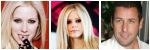

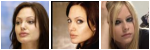

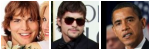

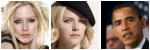

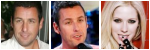

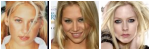

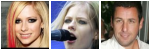

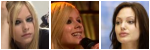

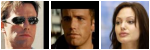

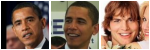

In [4]:

batch = data.getBatch(138, 'train')
print('batch = {aImg, pImg, nImg}: ', batch)
printTriplets(batch)

In [5]:
require 'nn'
alexnet = torch.load('alexnetowtbn_epoch55_cpu.t7')

In [6]:
function createModel(alexnet)
--     local alexnet = createModelAlex()
    --convNet = createModelAlex()
    local alexnet = alexnet:clone()
    alexnet:evaluate()
    alexnet:get(2):remove()
    alexnet:get(2):remove()
    alexnet:get(2):remove()
    alexnet:get(2):remove()

    convNet = alexnet
    convNet:get(2):add(nn.View(4096))
    convNet:get(2):add(nn.Linear(4096, 128))
    convNet:get(2):add(nn.Normalize(2))
    convNetPos = convNet:clone('weight', 'bias', 'gradWeight', 'gradBias')
    convNetNeg = convNet:clone('weight', 'bias', 'gradWeight', 'gradBias')
    -- Parallel container
    parallel = nn.ParallelTable()
    parallel:add(convNet)
    parallel:add(convNetPos)
    parallel:add(convNetNeg)
    return parallel
end

function computeSimilarity(x, y)
    -- use L2 norm distance
    return torch.dist(x, y)
end

In [11]:
imgDim = 224

local conv = nn.SpatialConvolutionMM
local relu = nn.ReLU
local mp = nn.SpatialMaxPooling

function createModelVGG()
   local net = nn.Sequential()

   net:add(conv(3, 64, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(64, 64, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(64, 128, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(128, 128, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(128, 256, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(256, 256, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(256, 256, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(256, 512, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))

   -- Validate shape with:
   -- net:add(nn.Reshape(25088))

   net:add(nn.View(25088))
   net:add(nn.Linear(25088, 4096))
   net:add(relu(true))

   net:add(nn.Linear(4096, 128))
   net:add(nn.Normalize(2))

   return net
end

function createModelAlex()
    local net = nn.Sequential()
    local fb1 = nn.Sequential()
    fb1:add(nn.SpatialConvolution(3,64,11,11,4,4,2,2))       -- 224 -> 55
    fb1:add(nn.ReLU(true))
    fb1:add(nn.SpatialMaxPooling(3,3,2,2))                   -- 55 ->  27
    fb1:add(nn.SpatialConvolution(64,192,5,5,1,1,2,2))       --  27 -> 27
    fb1:add(nn.ReLU(true))
    fb1:add(nn.SpatialMaxPooling(3,3,2,2))                   --  27 ->  13
    fb1:add(nn.SpatialConvolution(192,384,3,3,1,1,1,1))      --  13 ->  13
    fb1:add(nn.ReLU(true))
    fb1:add(nn.SpatialConvolution(384,256,3,3,1,1,1,1))      --  13 ->  13
    fb1:add(nn.ReLU(true))
    fb1:add(nn.SpatialConvolution(256,256,3,3,1,1,1,1))      --  13 ->  13
    fb1:add(nn.ReLU(true))
    fb1:add(nn.SpatialMaxPooling(3,3,2,2))                   -- 13 -> 6

    local classifier = nn.Sequential()
    classifier:add(nn.View(256*6*6))
    classifier:add(nn.Dropout(0.5))
    classifier:add(nn.Linear(256*6*6, 4096))
    classifier:add(nn.Threshold(0, 1e-6))
    classifier:add(nn.Dropout(0.5))
--     classifier:add(nn.View(4096))
    classifier:add(nn.Linear(4096, 128))
    classifier:add(nn.Normalize(2))
    
    net:add(fb1)
    net:add(classifier)
    return net
end

In [7]:
require 'nn'

--Load the AlexNet model
meanStd = torch.load('alexnetowtbn_meanStd.t7')

-- Pre-process the image channel by channel.
function preprocess(im)
    local output_image = image.scale(im:clone(), 224, 224)
    for i = 1, 3 do -- channels
        output_image[{{i},{},{}}]:add(-meanStd.mean[i])
        output_image[{{i},{},{}}]:div(meanStd.std[i])
    end
    return output_image
end

In [10]:
require 'nn'
require 'TripletEmbedding'

local criterion = nn.TripletEmbeddingCriterion()

function trainModel(model, opt)
    -- Get all the parameters (and gradients) of the model in a single vector.
    print("getting params")
    -- local params, gradParams = model:getParameters()
    local singleNet = model.modules[1]
    local opt = opt or {}
    local batchSize = opt.batchSize or 10  -- The bigger the batch size the most accurate the gradients.
    local numEpochs = opt.numEpochs or 3
    print("getting batches")
    local trainBatches = data.getNbOfBatches(batchSize).train
    print('trainBatches: ', trainBatches)
    local numEpochs = trainBatches
    -- Go over the training data this number of times.
     for epoch = 1, 250 do
        local sum_loss = 0
        local correct = 0
        local inputs = data.getBatch((epoch%10)+1, 'train')

        -- Run over the training set samples.
        -- set internal var Train=True so that layers like Dropout behave correctly. Also see :evaluate()
        model:training()
        -- 2. Perform the forward pass (prediction mode).
        --:view(1, 3, 224, 224)
        wrapperTotal = torch.Tensor(3, 10, 3, 224, 224)
        for apn = 1, 3 do
            for batchN = 1, batchSize do
                wrapper = torch.Tensor(1, 3, 224, 224)
                wrapper[1] = image.scale(inputs[apn][batchN], 224, 224)
                wrapperTotal[apn][batchSize] = wrapper
            end
        end
        wrapper = torch.Tensor(1, 3, 224, 224)
        wrapper[1] = image.scale(inputs[1][1], 224, 224)
        wrapper2 = torch.Tensor(1, 3, 224, 224)
        wrapper2[1] = image.scale(inputs[1][2], 224, 224)
        wrapper3 = torch.Tensor(1, 3, 224, 224)
        wrapper3[1] = image.scale(inputs[1][3], 224, 224)
        --print("finished wrapping")
        local predictions = model:forward(wrapperTotal)
        --print("passed")
        -- 3. Evaluate results.
        --for i = 1, predictions:size(1) do
        --    local _, predicted_label = predictions[i]:max(1)
        --    if predicted_label[1] == labels[i] then correct = correct + 1 end
        --end
        local sum_loss = sum_loss + criterion:forward(predictions)
--         print("passed stage 2")
        -- TODO: need to figure out how to change this to accomandate the BCECriterion
        -- 4. Perform the backward pass (compute derivatives).
        -- This zeroes-out all the parameters inside the model pointed by variable params.
        model:zeroGradParameters()
--          print("passed stage 3")
        -- This internally computes the gradients with respect to the parameters pointed by gradParams.
        local gradPredictions = criterion:backward(predictions)
--          print("passed stage 4")
        --{wrapper, wrapper2, wrapper3}
        model:backward(wrapperTotal, gradPredictions)
--          print("passed stage 5")
         -- 5. Perform the SGD update.
        model:updateParameters(0.01)
        if epoch % 10 == 0 then  -- Print this every 10 epochs.
            print(('train epoch=%d, avg-loss=%.6f')
                :format(epoch, sum_loss / epoch))
        end

        -- Run over the validation set for evaluation.
        print(epoch)
        itorch.image({image.scale(inputs[1][1], 48, 48), image.scale(inputs[2][1], 48, 48), 
                image.scale(inputs[3][1], 48, 48)})
        local ap = computeSimilarity(predictions[1][1], predictions[2][1])
        local an = computeSimilarity(predictions[1][1], predictions[3][1])
        print(('\na-->p %.4f'):format(ap))
        print(('\na-->n %.4f'):format(an))
        --print(('\nvalidation accuracy at epoch = %d is %.4f'):format(epoch, validation_accuracy))
    end
end

In [11]:
model = createModel(alexnet)


getting params	
getting batches	
trainBatches: 	138	


1	

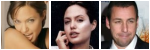


a-->p 0.0026	



a-->n 0.0004	


2	


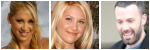


a-->p 0.0017	



a-->n 0.0008	


3	



a-->p 0.0086	

a-->n 0.0086	


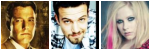

4	



a-->p 0.0007	

a-->n 0.0007	


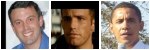

5	


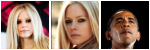


a-->p 0.0000	

a-->n 0.0011	


6	


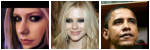


a-->p 0.0000	



a-->n 0.0011	


7	



a-->p 0.0000	

a-->n 0.0000	


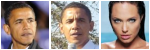

8	


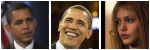


a-->p 0.8738	

a-->n 0.5605	


9	

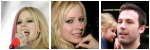


a-->p 0.2300	



a-->n 0.2150	

train epoch=10, avg-loss=0.061887	


10	



a-->p 0.2213	

a-->n 0.1628	


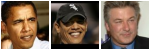

11	

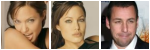


a-->p 0.0004	



a-->n 0.0004	


12	


a-->p 0.0004	

a-->n 0.0003	


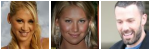

13	

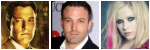


a-->p 0.0000	

a-->n 0.0000	


14	

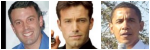


a-->p 0.0004	

a-->n 0.0001	


15	

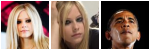


a-->p 0.0000	



a-->n 0.0000	


16	


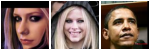


a-->p 0.0001	

a-->n 0.0001	


17	

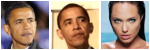


a-->p 0.0001	

a-->n 0.0000	


18	

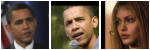


a-->p 0.0001	

a-->n 0.0000	


19	


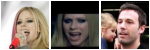


a-->p 0.0000	

a-->n 0.0004	


train epoch=20, avg-loss=0.010040	

20	


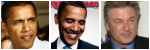


a-->p 0.0001	

a-->n 0.0000	


21	



a-->p 0.0000	

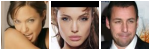



a-->n 0.0007	


22	


a-->p 0.0001	

a-->n 0.0000	


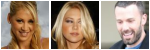

23	


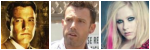


a-->p 0.0000	

a-->n 0.0000	


24	


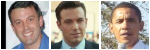


a-->p 0.0000	

a-->n 0.0001	


25	


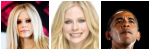


a-->p 0.0001	

a-->n 0.0001	


26	


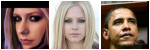


a-->p 0.0005	


a-->n 0.0005	

27	


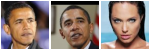


a-->p 0.4588	

a-->n 0.4590	


28	


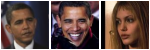


a-->p 0.0006	

a-->n 0.0000	


29	

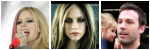


a-->p 0.0002	

a-->n 0.0000	


train epoch=30, avg-loss=0.006654	
30	


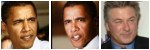


a-->p 0.0001	

a-->n 0.0004	


31	


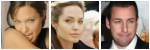


a-->p 0.0001	

a-->n 0.0001	


32	


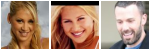


a-->p 0.0005	



a-->n 0.0003	


33	

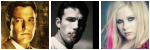


a-->p 0.0000	

a-->n 0.0000	


34	


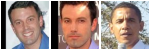


a-->p 0.0000	

a-->n 0.0000	


35	


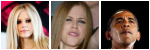


a-->p 0.1808	

a-->n 0.1686	


36	

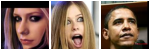


a-->p 0.0000	

a-->n 0.0000	


37	

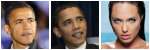


a-->p 0.3383	

a-->n 0.3383	


38	

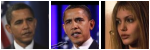


a-->p 0.0000	

a-->n 0.0000	


39	


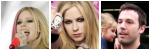


a-->p 0.0003	

a-->n 0.0003	


train epoch=40, avg-loss=0.005001	


40	


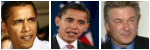


a-->p 0.0005	



a-->n 0.0005	


41	



a-->p 0.3158	

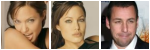



a-->n 0.3156	


42	

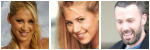


a-->p 0.0003	

a-->n 0.0002	


43	

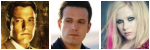


a-->p 0.0005	

a-->n 0.0000	


44	


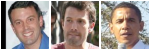


a-->p 0.3552	

a-->n 0.3554	


45	

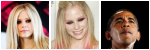


a-->p 0.0005	

a-->n 0.0000	


46	


a-->p 0.0007	

a-->n 0.0007	


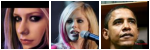

47	


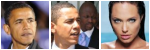


a-->p 0.0000	

a-->n 0.0000	


48	

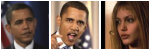


a-->p 0.0003	



a-->n 0.0002	

49	

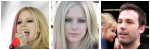


a-->p 0.1899	

a-->n 0.1395	


train epoch=50, avg-loss=0.004005	


50	


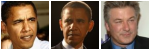


a-->p 0.2696	

a-->n 0.2696	


51	


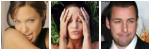


a-->p 0.3875	

a-->n 0.3874	


52	


a-->p 0.0001	

a-->n 0.0005	


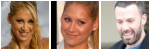

53	

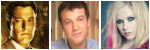


a-->p 0.0000	

a-->n 0.0000	


54	

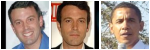


a-->p 0.2574	

a-->n 0.2573	


55	


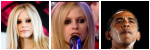


a-->p 0.3647	



a-->n 0.3647	


56	

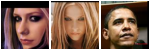


a-->p 0.0001	

a-->n 0.0001	


57	



a-->p 0.2765	

a-->n 0.2765	


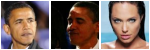

58	



a-->p 0.3635	

a-->n 0.3637	


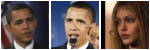

59	


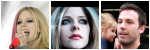


a-->p 0.0000	

a-->n 0.0004	


train epoch=60, avg-loss=0.003331	
60	



a-->p 0.0000	

a-->n 0.0006	


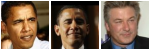

61	

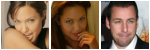


a-->p 0.0000	

a-->n 0.0006	


62	


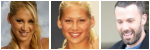


a-->p 0.0000	



a-->n 0.0003	


63	


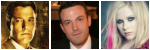


a-->p 0.1605	

a-->n 0.1752	


64	


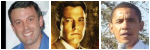


a-->p 0.0000	

a-->n 0.0000	


65	


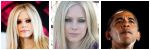


a-->p 0.0001	

a-->n 0.0000	


66	

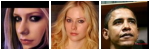


a-->p 0.0003	

a-->n 0.0000	


67	


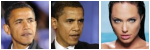


a-->p 0.0000	

a-->n 0.0000	


68	


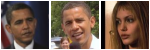


a-->p 0.1960	

a-->n 0.1960	


69	


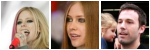


a-->p 0.2567	

a-->n 0.2567	


train epoch=70, avg-loss=0.002843	
70	


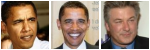


a-->p 0.0004	

a-->n 0.0000	


71	


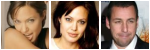


a-->p 0.0000	

a-->n 0.0002	


72	


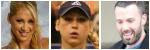


a-->p 0.0000	

a-->n 0.0000	


73	



a-->p 0.2364	

a-->n 0.2364	


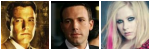

74	

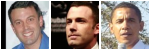


a-->p 0.2459	

a-->n 0.2458	


75	

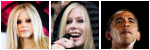


a-->p 0.2694	

a-->n 0.2696	


76	


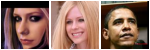


a-->p 0.0004	



a-->n 0.0000	


77	


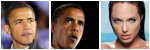


a-->p 0.1462	

a-->n 0.1532	


78	


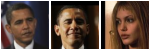


a-->p 0.1659	

a-->n 0.1659	


79	

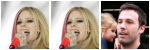


a-->p 0.0000	

a-->n 0.0006	


train epoch=80, avg-loss=0.002496	
80	


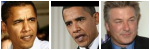


a-->p 0.2161	

a-->n 0.2161	


81	



a-->p 0.0003	

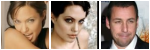



a-->n 0.0005	


82	


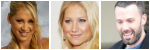


a-->p 0.0000	

a-->n 0.0000	


83	


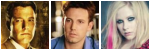


a-->p 0.1708	

a-->n 0.1708	


84	


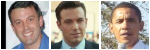


a-->p 0.1966	

a-->n 0.1966	


85	


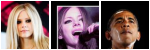


a-->p 0.0003	


a-->n 0.0003	

86	


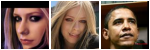


a-->p 0.0000	

a-->n 0.0000	


87	

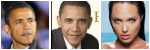


a-->p 0.2119	

a-->n 0.2117	


88	


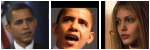


a-->p 0.1817	

a-->n 0.1817	


89	


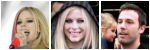


a-->p 0.0000	

a-->n 0.0000	


train epoch=90, avg-loss=0.002235	


90	


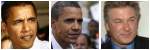


a-->p 0.1884	

a-->n 0.1883	


91	


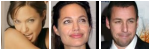


a-->p 0.1772	

a-->n 0.1477	


92	

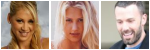


a-->p 0.1699	

a-->n 0.1699	


93	


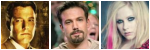


a-->p 0.1753	

a-->n 0.1754	


94	


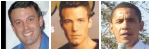


a-->p 0.0000	

a-->n 0.0004	


95	

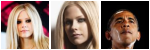


a-->p 0.1548	

a-->n 0.1547	


96	

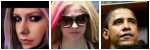


a-->p 0.0001	

a-->n 0.0000	


97	


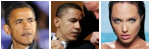


a-->p 0.1614	

a-->n 0.1614	


98	

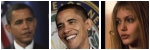


a-->p 0.1594	

a-->n 0.1594	


99	

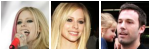


a-->p 0.1553	

a-->n 0.1552	


train epoch=100, avg-loss=0.001991	
100	


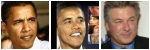


a-->p 0.1703	

a-->n 0.1704	


101	


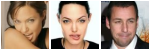


a-->p 0.1577	

a-->n 0.1578	


102	

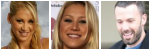


a-->p 0.1637	

a-->n 0.1636	


103	


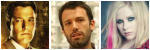


a-->p 0.1766	



a-->n 0.1766	


104	


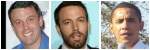


a-->p 0.1614	

a-->n 0.1614	


105	


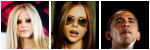


a-->p 0.1716	

a-->n 0.2003	


106	

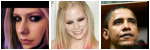


a-->p 0.1406	

a-->n 0.1407	


107	

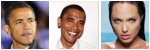


a-->p 0.1526	

a-->n 0.1526	


108	

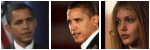


a-->p 0.1543	

a-->n 0.1543	


109	

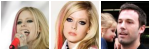


a-->p 0.0000	

a-->n 0.0000	


train epoch=110, avg-loss=0.001822	
110	


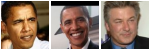


a-->p 0.1442	

a-->n 0.1442	


111	

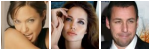


a-->p 0.1506	

a-->n 0.1506	


112	


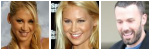


a-->p 0.1435	

a-->n 0.1434	


113	


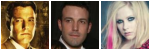


a-->p 0.1412	



a-->n 0.1412	


114	

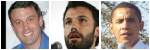


a-->p 0.1605	

a-->n 0.1605	


115	

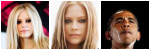


a-->p 0.1345	

a-->n 0.1344	


116	


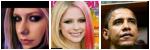


a-->p 0.1484	

a-->n 0.1484	


117	


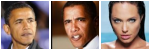


a-->p 0.1412	

a-->n 0.1412	


118	

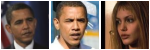


a-->p 0.1768	



a-->n 0.1768	


119	


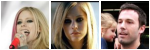


a-->p 0.1648	

a-->n 0.2219	


train epoch=120, avg-loss=0.001675	
120	


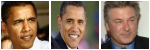


a-->p 0.1649	

a-->n 0.1649	


121	


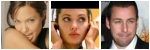


a-->p 0.1563	



a-->n 0.1563	


122	


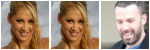


a-->p 0.0003	

a-->n 0.0005	


123	


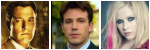


a-->p 0.1679	



a-->n 0.1679	


124	

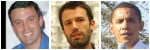


a-->p 0.2138	

a-->n 0.2139	


125	

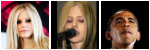


a-->p 0.2340	

a-->n 0.2341	


126	


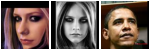


a-->p 0.1770	

a-->n 0.1770	


127	


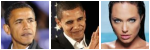


a-->p 0.1836	



a-->n 0.1836	


128	


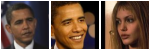


a-->p 0.2317	

a-->n 0.2317	


129	



a-->p 0.1836	

a-->n 0.1836	


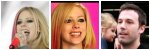

train epoch=130, avg-loss=0.001554	

130	

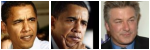


a-->p 0.1720	

a-->n 0.1720	


131	

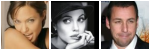


a-->p 0.1717	



a-->n 0.1717	


132	

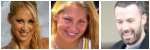


a-->p 0.1589	



a-->n 0.1588	


133	

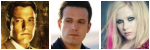


a-->p 0.1854	

a-->n 0.2273	


134	



a-->p 0.1829	


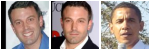


a-->n 0.1829	


135	


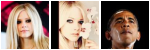


a-->p 0.1978	

a-->n 0.1978	


136	



a-->p 0.2472	

a-->n 0.2472	


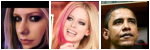

137	


a-->p 0.1686	

a-->n 0.1687	


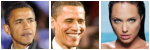

138	


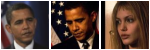


a-->p 0.1912	

a-->n 0.1912	


139	

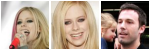


a-->p 0.2016	

a-->n 0.2016	


train epoch=140, avg-loss=0.001426	


140	


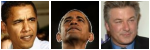


a-->p 0.1975	

a-->n 0.1975	


141	


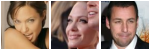


a-->p 0.1762	

a-->n 0.1760	


142	


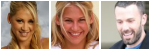


a-->p 0.2069	

a-->n 0.2069	


143	

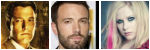


a-->p 0.2098	

a-->n 0.2098	


144	

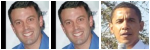


a-->p 0.1941	

a-->n 0.1941	


145	


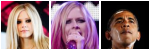


a-->p 0.2566	

a-->n 0.2566	


146	


a-->p 0.1950	

a-->n 0.1950	


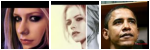

147	


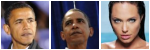


a-->p 0.1630	



a-->n 0.2232	


148	

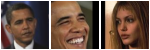


a-->p 0.1871	

a-->n 0.1871	


149	

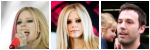


a-->p 0.2269	

a-->n 0.2268	


train epoch=150, avg-loss=0.001342	


150	


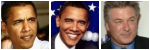


a-->p 0.2445	

a-->n 0.2445	


151	


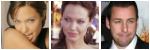


a-->p 0.2200	

a-->n 0.2200	


152	


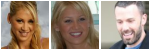


a-->p 0.2772	

a-->n 0.2772	


153	

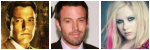


a-->p 0.2401	

a-->n 0.2401	


154	


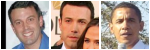


a-->p 0.2381	

a-->n 0.2381	


155	


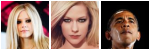


a-->p 0.2014	



a-->n 0.2014	

156	



a-->p 0.2192	

a-->n 0.2192	


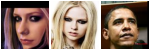

157	



a-->p 0.1893	

a-->n 0.1894	


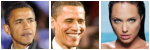

158	


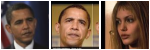


a-->p 0.2068	



a-->n 0.2068	

159	

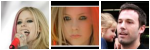


a-->p 0.2063	

a-->n 0.2063	


train epoch=160, avg-loss=0.001248	


160	


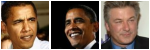


a-->p 0.1978	

a-->n 0.1978	


161	


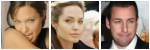


a-->p 0.2019	

a-->n 0.2508	


162	

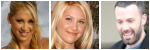


a-->p 0.2449	

a-->n 0.2447	


163	

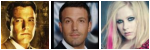


a-->p 0.2764	

a-->n 0.2765	


164	

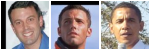


a-->p 0.3534	

a-->n 0.3534	


165	

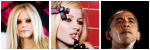


a-->p 0.2645	

a-->n 0.2645	


166	


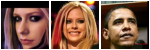


a-->p 0.2651	

a-->n 0.2653	


167	

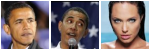


a-->p 0.2422	

a-->n 0.2422	


168	


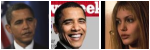


a-->p 0.2452	

a-->n 0.2451	


169	

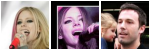


a-->p 0.2300	



a-->n 0.2300	


train epoch=170, avg-loss=0.001171	


170	

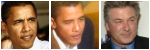


a-->p 0.2597	

a-->n 0.2596	


171	

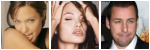


a-->p 0.2608	



a-->n 0.2606	


172	


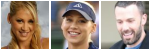


a-->p 0.2186	



a-->n 0.2186	


173	


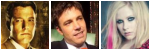


a-->p 0.2566	

a-->n 0.2566	


174	


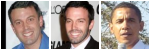


a-->p 0.2679	


a-->n 0.2678	


175	

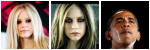


a-->p 0.2152	



a-->n 0.2588	


176	

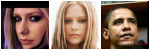


a-->p 0.2620	

a-->n 0.2620	


177	


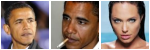


a-->p 0.2788	

a-->n 0.2788	


178	


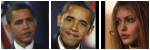


a-->p 0.3945	

a-->n 0.3946	


179	


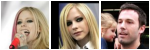


a-->p 0.3056	

a-->n 0.3056	


train epoch=180, avg-loss=0.001110	


180	


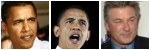


a-->p 0.3295	

a-->n 0.3295	


181	

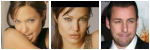


a-->p 0.3124	

a-->n 0.3124	


182	


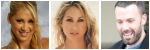


a-->p 0.3215	

a-->n 0.3215	


183	

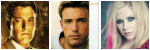


a-->p 0.3062	

a-->n 0.3062	


184	

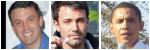


a-->p 0.2947	

a-->n 0.2947	


185	

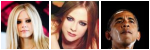


a-->p 0.2925	

a-->n 0.2924	


186	


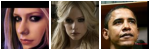


a-->p 0.2690	

a-->n 0.2690	


187	


a-->p 0.2629	

a-->n 0.2629	


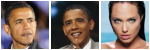

188	

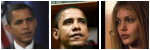


a-->p 0.2986	

a-->n 0.2986	


189	


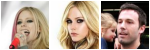


a-->p 0.1826	

a-->n 0.2648	


train epoch=190, avg-loss=0.001057	
190	


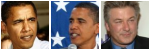


a-->p 0.3768	

a-->n 0.3768	


191	


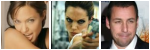


a-->p 0.3697	

a-->n 0.3695	


192	


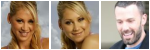


a-->p 0.3644	

a-->n 0.3644	


193	

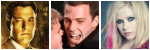


a-->p 0.3790	

a-->n 0.3790	


194	


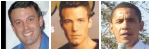


a-->p 0.3370	

a-->n 0.3370	


195	

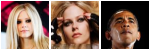


a-->p 0.3682	

a-->n 0.3681	


196	



a-->p 0.3507	

a-->n 0.3507	


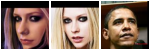

197	


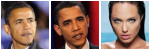


a-->p 0.3668	



a-->n 0.3668	


198	


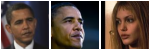


a-->p 0.3785	

a-->n 0.3785	


199	

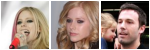


a-->p 0.3772	

a-->n 0.3772	


train epoch=200, avg-loss=0.001001	

200	


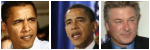


a-->p 0.3369	

a-->n 0.3369	


201	

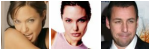


a-->p 0.3563	

a-->n 0.3563	


202	

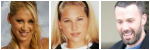


a-->p 0.3907	

a-->n 0.3907	


203	


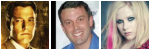


a-->p 0.1660	

a-->n 0.2106	


204	

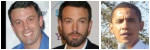


a-->p 0.3812	

a-->n 0.3812	


205	

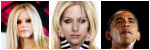


a-->p 0.3741	



a-->n 0.3741	


206	


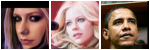


a-->p 0.3665	

a-->n 0.3665	


207	


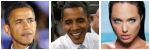


a-->p 0.3511	



a-->n 0.3511	


208	


a-->p 0.3464	

a-->n 0.3464	


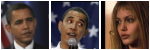

209	


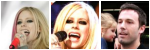


a-->p 0.3379	

a-->n 0.3379	


train epoch=210, avg-loss=0.000944	
210	



a-->p 0.4149	

a-->n 0.4149	


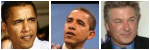

211	


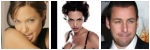


a-->p 0.3901	

a-->n 0.3901	


212	

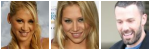


a-->p 0.3381	

a-->n 0.3381	


213	

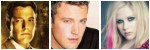


a-->p 0.3802	

a-->n 0.3802	


214	


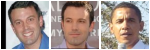


a-->p 0.3351	



a-->n 0.3351	

215	

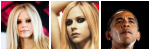


a-->p 0.3785	

a-->n 0.3785	


216	


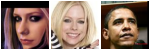


a-->p 0.3787	

a-->n 0.3787	

217	


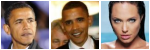


a-->p 0.2944	

a-->n 0.1476	


218	


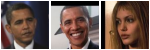


a-->p 0.2841	

a-->n 0.2841	


219	

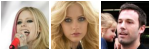


a-->p 0.3123	

a-->n 0.3123	


train epoch=220, avg-loss=0.000900	
220	


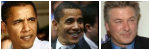


a-->p 0.2582	



a-->n 0.2582	


221	


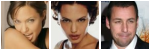


a-->p 0.3216	

a-->n 0.3216	


222	



a-->p 0.3147	

a-->n 0.3147	


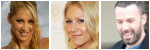

223	


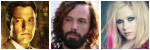


a-->p 0.2947	

a-->n 0.2947	


224	


a-->p 0.2699	

a-->n 0.2699	


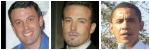

225	

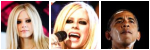


a-->p 0.2777	

a-->n 0.2777	


226	



a-->p 0.3325	

a-->n 0.3325	


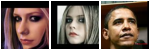

227	


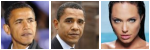


a-->p 0.3036	

a-->n 0.3036	

228	

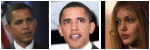


a-->p 0.3309	

a-->n 0.3309	


229	

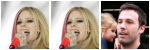


a-->p 0.3072	

a-->n 0.3072	


train epoch=230, avg-loss=0.000862	
230	


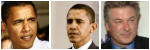


a-->p 0.2819	

a-->n 0.2819	


231	


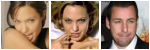


a-->p 0.1860	



a-->n 0.2965	


232	

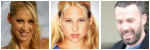


a-->p 0.3782	

a-->n 0.3782	


233	


a-->p 0.3171	


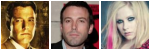


a-->n 0.3171	


234	

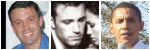


a-->p 0.3752	

a-->n 0.3752	


235	


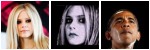


a-->p 0.2803	

a-->n 0.2803	


236	


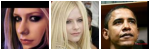


a-->p 0.3249	

a-->n 0.3249	


237	


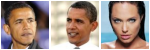


a-->p 0.3430	

a-->n 0.3430	


238	


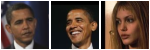


a-->p 0.3750	

a-->n 0.3750	


239	

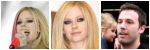


a-->p 0.3294	

a-->n 0.3294	


train epoch=240, avg-loss=0.000840	
240	


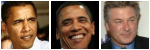


a-->p 0.3218	

a-->n 0.3218	


241	


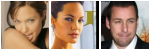


a-->p 0.3665	

a-->n 0.3665	


242	


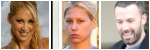


a-->p 0.3538	

a-->n 0.3538	


243	


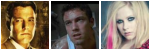


a-->p 0.3718	



a-->n 0.3718	


244	

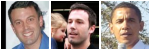


a-->p 0.3393	

a-->n 0.3393	


245	


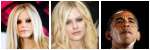


a-->p 0.1955	

a-->n 0.2006	


246	

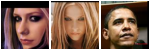


a-->p 0.3544	

a-->n 0.3544	


247	


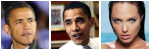


a-->p 0.3291	

a-->n 0.3291	


248	


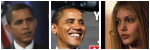


a-->p 0.3250	

a-->n 0.3250	


249	


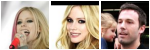


a-->p 0.3592	

a-->n 0.3592	


train epoch=250, avg-loss=0.000782	
250	


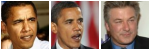


a-->p 0.3365	

a-->n 0.3365	



In [12]:
trainModel(model:clone(), {})